In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from scipy import stats as ss
from statsmodels.graphics.tsaplots import plot_pacf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/ms_wind_curtailment_prediction/curtailment_target_features.csv", sep=";", index_col=0)

In [5]:
df.isnull().sum()

redispatch                           0
level                                0
wind_speed_m/s                      16
wind_direction_degrees              16
radiation_global_J/m2               16
air_temperature_K                   16
humidity_percent                    16
wind_gust_max_m/s                   16
wind_direction_gust_max_degrees     16
forecast_solar_MW                  112
actual_solar_MW                    197
total_grid_load_MWh                 16
residual_load_MWh                   16
pumped_storage_MWh                  16
dtype: int64

Imputing NaN values

In [6]:
# Loop through DataFrame rows
for index, row in df.iterrows():
    # Check if column 'forecast_solar_MW' is NaN
    if pd.isna(row['forecast_solar_MW']):
        # If 'forecast_solar_MW' is NaN, fill it with the value from 'actual_solar_MW'
        df.at[index, 'forecast_solar_MW'] = row['actual_solar_MW']

    if pd.isna(row['actual_solar_MW']):
      df.at[index, 'actual_solar_MW'] = row['forecast_solar_MW']


columns_to_interpolate = ["wind_speed_m/s",  "wind_direction_degrees", "humidity_percent", "radiation_global_J/m2", "air_temperature_K", "wind_gust_max_m/s", "wind_direction_gust_max_degrees", "forecast_solar_MW", "actual_solar_MW", "total_grid_load_MWh", "residual_load_MWh", "pumped_storage_MWh"]

# Assuming df is your DataFrame with missing values
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear', limit_direction='both')

**Visualising Redispatch against Time**

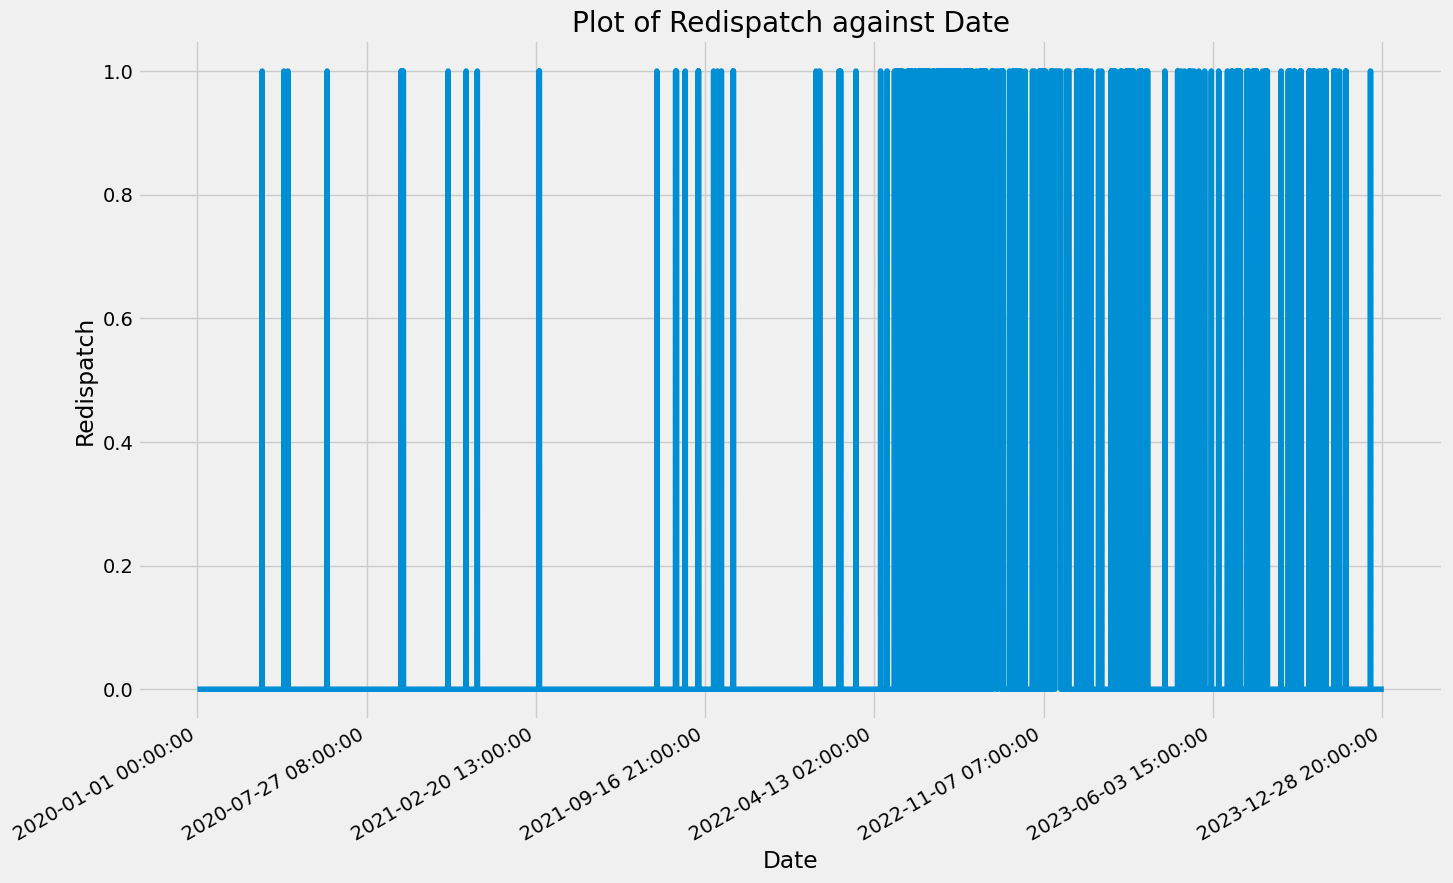

In [7]:
# Plot the column against the datetime index
df['redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()

**Train - Test - Split**

In [21]:
redispatch_df = df.copy()
redispatch_df.index = pd.to_datetime(redispatch_df.index)
redispatch_df.drop('level', inplace=True, axis=1)
redispatch_df.head()
#redispatch_df = df.reset_index(drop=True).copy(deep=True)

,redispatch,wind_speed_m/s,wind_direction_degrees,radiation_global_J/m2,air_temperature_K,humidity_percent,wind_gust_max_m/s,wind_direction_gust_max_degrees,forecast_solar_MW,actual_solar_MW,total_grid_load_MWh,residual_load_MWh,pumped_storage_MWh
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,2.1,250.0,0.0,278.45,80.70,3.30,250.0,0.0,0.0,730.95,624.18,3.25
2020-01-01 00:15:00,0.0,2.7,265.0,0.0,278.55,79.95,4.25,265.0,0.0,0.0,727.23,620.78,4.35
2020-01-01 00:30:00,0.0,2.4,240.0,0.0,278.45,80.40,3.50,250.0,0.0,0.0,722.20,611.37,6.40
2020-01-01 00:45:00,0.0,2.7,250.0,0.0,278.55,79.45,3.80,245.0,0.0,0.0,719.22,604.33,8.32
2020-01-01 01:00:00,0.0,2.7,260.0,0.0,278.45,80.50,3.90,260.0,0.0,0.0,717.07,600.83,6.32


In [ ]:
#redispatch_df = redispatch_df.drop(columns=['level', 'wind_speed_m/s', 'wind_direction_degrees',
#       'radiation_global_J/m2', 'air_temperature_K', 'humidity_percent',
#       'wind_gust_max_m/s', 'wind_direction_gust_max_degrees',
#       'forecast_solar_MW', 'actual_solar_MW', 'total_grid_load_MWh',
#       'residual_load_MWh', 'pumped_storage_MWh'])

In [22]:
# Split the entire dataset into training and test sets
cutoff_time = "2023-01-01"

# train data
train = redispatch_df[redispatch_df.index < cutoff_time]
#X_train = train.drop(['redispatch', 'level'], axis = 1)
#y_train = train['redispatch']

# test data
test = redispatch_df[redispatch_df.index >= cutoff_time]
#X_test = test.drop(['redispatch', 'level'], axis = 1)
#y_test = test['redispatch']

In [23]:
r_df = redispatch_df.copy()
r_df.head()

,redispatch,wind_speed_m/s,wind_direction_degrees,radiation_global_J/m2,air_temperature_K,humidity_percent,wind_gust_max_m/s,wind_direction_gust_max_degrees,forecast_solar_MW,actual_solar_MW,total_grid_load_MWh,residual_load_MWh,pumped_storage_MWh
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,2.1,250.0,0.0,278.45,80.70,3.30,250.0,0.0,0.0,730.95,624.18,3.25
2020-01-01 00:15:00,0.0,2.7,265.0,0.0,278.55,79.95,4.25,265.0,0.0,0.0,727.23,620.78,4.35
2020-01-01 00:30:00,0.0,2.4,240.0,0.0,278.45,80.40,3.50,250.0,0.0,0.0,722.20,611.37,6.40
2020-01-01 00:45:00,0.0,2.7,250.0,0.0,278.55,79.45,3.80,245.0,0.0,0.0,719.22,604.33,8.32
2020-01-01 01:00:00,0.0,2.7,260.0,0.0,278.45,80.50,3.90,260.0,0.0,0.0,717.07,600.83,6.32


In [25]:
def create_features(redispatch_df):
    """
    Create time series features based on time series index.
    """
    redispatch_df = redispatch_df.copy()
    redispatch_df['hour'] = redispatch_df.index.hour
    redispatch_df['dayofweek'] = redispatch_df.index.dayofweek
    redispatch_df['quarter'] = redispatch_df.index.quarter
    redispatch_df['month'] = redispatch_df.index.month
    redispatch_df['year'] = redispatch_df.index.year
    redispatch_df['dayofyear'] = redispatch_df.index.dayofyear
    redispatch_df['dayofmonth'] = redispatch_df.index.day
    redispatch_df['weekofyear'] = redispatch_df.index.isocalendar().week
    return redispatch_df

r_df = create_features(redispatch_df)

In [26]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'redispatch'

X_train = train.drop(['redispatch'], axis = 1)
#X_train = train[FEATURES]
# Iterate over each datetime property and create new columns in X_train
for prop in FEATURES:
    X_train[prop] = getattr(train.index, prop)

y_train = train[TARGET]

X_test = test.drop(['redispatch'], axis = 1)
for prop in FEATURES:
    X_test[prop] = getattr(test.index, prop)
#X_test = test[FEATURES]

y_test = test[TARGET]

print(X_train.columns)

Index(['wind_speed_m/s', 'wind_direction_degrees', 'radiation_global_J/m2',
       'air_temperature_K', 'humidity_percent', 'wind_gust_max_m/s',
       'wind_direction_gust_max_degrees', 'forecast_solar_MW',
       'actual_solar_MW', 'total_grid_load_MWh', 'residual_load_MWh',
       'pumped_storage_MWh', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')


In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105252 entries, 2020-01-01 00:00:00 to 2022-12-31 23:45:00
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   wind_speed_m/s                   105252 non-null  float64
 1   wind_direction_degrees           105252 non-null  float64
 2   radiation_global_J/m2            105252 non-null  float64
 3   air_temperature_K                105252 non-null  float64
 4   humidity_percent                 105252 non-null  float64
 5   wind_gust_max_m/s                105252 non-null  float64
 6   wind_direction_gust_max_degrees  105252 non-null  float64
 7   forecast_solar_MW                105252 non-null  float64
 8   actual_solar_MW                  105252 non-null  float64
 9   total_grid_load_MWh              105252 non-null  float64
 10  residual_load_MWh                105252 non-null  float64
 11  pumped_storage_MWh             

In [ ]:
X_train.head()

,wind_speed_m/s,wind_direction_degrees,radiation_global_J/m2,air_temperature_K,humidity_percent,wind_gust_max_m/s,wind_direction_gust_max_degrees,forecast_solar_MW,actual_solar_MW,total_grid_load_MWh,residual_load_MWh,pumped_storage_MWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2.1,250.0,0.0,278.45,80.70,3.30,250.0,0.0,0.0,730.95,624.18,3.25,0,2,1,1,2020,1,1,1
2020-01-01 00:15:00,2.7,265.0,0.0,278.55,79.95,4.25,265.0,0.0,0.0,727.23,620.78,4.35,0,2,1,1,2020,1,1,1
2020-01-01 00:30:00,2.4,240.0,0.0,278.45,80.40,3.50,250.0,0.0,0.0,722.20,611.37,6.40,0,2,1,1,2020,1,1,1
2020-01-01 00:45:00,2.7,250.0,0.0,278.55,79.45,3.80,245.0,0.0,0.0,719.22,604.33,8.32,0,2,1,1,2020,1,1,1
2020-01-01 01:00:00,2.7,260.0,0.0,278.45,80.50,3.90,260.0,0.0,0.0,717.07,600.83,6.32,1,2,1,1,2020,1,1,1


In [28]:
# preprocessing pipelines
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [29]:
# create model instance
xgboost_class = XGBClassifier(booster='gbtree',
                              n_estimators=1000,
                              max_depth=3,
                              learning_rate=1,
                              objective='binary:logistic',
                              random_state=9)

# Specify validation dataset
eval_set = [(X_train_preprocessed, y_train_preprocessed), (X_test_preprocessed, y_test)]  # You can modify this based on your dataset

# fit model with early stopping and verbose output
xgboost_class.fit(X_train_preprocessed, y_train_preprocessed, eval_set=eval_set, early_stopping_rounds=50, verbose=100)

# make predictions
y_pred = xgboost_class.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.33832	validation_1-logloss:1.03086
[59]	validation_0-logloss:0.06349	validation_1-logloss:1.03960


In [30]:
# evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.54      0.68     32472
         1.0       0.06      0.41      0.11      2484

    accuracy                           0.53     34956
   macro avg       0.49      0.47      0.39     34956
weighted avg       0.86      0.53      0.64     34956



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.33832	validation_1-logloss:1.03086
[60]	validation_0-logloss:0.06266	validation_1-logloss:1.04492


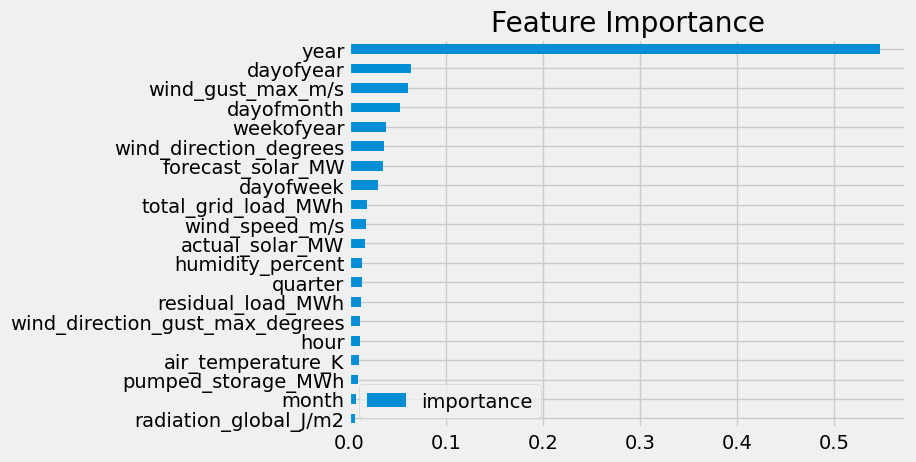

In [31]:
# Convert NumPy arrays to Pandas DataFrames
X_train_df = pd.DataFrame(data=X_train_preprocessed, columns=X_train.columns)
X_test_df = pd.DataFrame(data=X_test_preprocessed, columns=X_test.columns)

# Specify validation dataset
eval_set = [(X_train_df, y_train_preprocessed), (X_test_df, y_test)]  # Modified to use the Pandas DataFrames

# fit model with early stopping and verbose output
xgboost_class.fit(X_train_df, y_train_preprocessed, eval_set=eval_set, early_stopping_rounds=50, verbose=100)

# make predictions
y_pred = xgboost_class.predict(X_test_df)

# Create feature importance DataFrame
fi = pd.DataFrame(data=xgboost_class.feature_importances_,
                   index=X_train.columns,
                   columns=['importance'])

# Sort feature importance values and plot
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()
